In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch.utils.data import Subset
import copy

In [2]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [np.clip(im.permute(1,2,0).numpy(),0,1) for im in images]

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx])
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)
    
    # Showing the figure
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)
    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])
    return embedding

In [5]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

    def forward(self, x1, x2): # x1 (bs,out_ch,w1,h1) x2 (bs,in_ch,w2,h2)
        x2 = self.up_scale(x2) # (bs,out_ch,2*w2,2*h2)
        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2]) # (bs,out_ch,w1,h1)
        x = torch.cat([x2, x1], dim=1) # (bs,2*out_ch,w1,h1)
        return x

class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch): # !! 2*out_ch = in_ch !!
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2): # x1 (bs,out_ch,w1,h1) x2 (bs,in_ch,w2,h2)
        a = self.up(x1, x2) # (bs,2*out_ch,w1,h1)
        x = self.conv(a) # (bs,out_ch,w1,h1) because 2*out_ch = in_ch
        return x

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_steps=1000, time_emb_dim=100):
        super(UNet, self).__init__()
        self.conv1 = double_conv(in_channels, 64)
        self.down1 = down_layer(64, 128)
        self.down2 = down_layer(128, 256)
        self.down3 = down_layer(256, 512)
        self.down4 = down_layer(512, 1024)
        self.up1 = up_layer(1024, 512)
        self.up2 = up_layer(512, 256)
        self.up3 = up_layer(256, 128)
        self.up4 = up_layer(128, 64)
        self.last_conv = nn.Conv2d(64, in_channels, 1)
        
        # Time embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)
        self.te1 = self._make_te(time_emb_dim, in_channels)
        self.te2 = self._make_te(time_emb_dim, 64)
        self.te3 = self._make_te(time_emb_dim, 128)
        self.te4 = self._make_te(time_emb_dim, 256)
        self.te5 = self._make_te(time_emb_dim, 512)
        self.te1_up = self._make_te(time_emb_dim, 1024)
        self.te2_up = self._make_te(time_emb_dim, 512)
        self.te3_up = self._make_te(time_emb_dim, 256)
        self.te4_up = self._make_te(time_emb_dim, 128)

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))
    
    def forward(self, x , t): # x (bs,in_channels,w,d)
        bs = x.shape[0]
        t = self.time_embed(t)
        x1 = self.conv1(x+self.te1(t).reshape(bs, -1, 1, 1)) # (bs,64,w,d)
        x2 = self.down1(x1+self.te2(t).reshape(bs, -1, 1, 1)) # (bs,128,w/2,d/2)
        x3 = self.down2(x2+self.te3(t).reshape(bs, -1, 1, 1)) # (bs,256,w/4,d/4)
        x4 = self.down3(x3+self.te4(t).reshape(bs, -1, 1, 1)) # (bs,512,w/8,h/8)
        x5 = self.down4(x4+self.te5(t).reshape(bs, -1, 1, 1)) # (bs,1024,w/16,h/16)
        x1_up = self.up1(x4, x5+self.te1_up(t).reshape(bs, -1, 1, 1)) # (bs,512,w/8,h/8)
        x2_up = self.up2(x3, x1_up+self.te2_up(t).reshape(bs, -1, 1, 1)) # (bs,256,w/4,h/4)
        x3_up = self.up3(x2, x2_up+self.te3_up(t).reshape(bs, -1, 1, 1)) # (bs,128,w/2,h/2)
        x4_up = self.up4(x1, x3_up+self.te4_up(t).reshape(bs, -1, 1, 1)) # (bs,64,w,h)
        output = self.last_conv(x4_up) # (bs,in_channels,w,h)
        return output

In [7]:
bs = 3
x = torch.randn(bs,1,32,32)
n_steps=1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = UNet()

In [8]:
y = unet(x,timesteps)
y.shape


torch.Size([3, 1, 32, 32])

In [9]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5 # used in add_noise
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5 # used in add_noise and step

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        # x_start and x_noise (bs, n_c, w, d)
        # timesteps (bs)
        s1 = self.sqrt_alphas_cumprod[timesteps] # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps] # bs
        s1 = s1.reshape(-1,1,1,1) # (bs, 1, 1, 1) for broadcasting
        s2 = s2.reshape(-1,1,1,1) # (bs, 1, 1, 1)
        return s1 * x_start + s2 * x_noise

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)
    
    def step(self, model_output, timestep, sample):
        # one step of sampling
        # timestep (1)
        t = timestep
        coef_epsilon = (1-self.alphas)/self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].reshape(-1,1,1,1)
        coef_first = 1/self.alphas ** 0.5
        coef_first_t = coef_first[t].reshape(-1,1,1,1)
        pred_prev_sample = coef_first_t*(sample-coef_eps_t*model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise)
            
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

In [10]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    """Training loop for DDPM"""

    global_step = 0
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)
            noise = torch.randn(batch.shape).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)

            noisy = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(noisy, timesteps)
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        
        progress_bar.close()

In [11]:
IMAGE_SHAPE=(64,64)

In [12]:
transforms01 = torchvision.transforms.Compose([
        transforms.Resize(IMAGE_SHAPE),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [13]:
from torchvision import datasets
train_data=datasets.ImageFolder(root="/kaggle/input/flowers-recognition/flowers",transform=transforms01,target_transform=None)

In [14]:
dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=512, shuffle=True,num_workers=2)


In [15]:
train_data[0]

(tensor([[[0.5529, 0.5804, 0.6000,  ..., 0.6392, 0.6118, 0.5961],
          [0.5373, 0.5725, 0.6314,  ..., 0.6235, 0.6078, 0.5843],
          [0.5098, 0.5490, 0.6039,  ..., 0.6157, 0.6039, 0.5569],
          ...,
          [0.1569, 0.1647, 0.2196,  ..., 0.5020, 0.4980, 0.4941],
          [0.1686, 0.1725, 0.2118,  ..., 0.5216, 0.5059, 0.5059],
          [0.1725, 0.1804, 0.2118,  ..., 0.5373, 0.5216, 0.5137]],
 
         [[0.5529, 0.5804, 0.5961,  ..., 0.6353, 0.6078, 0.5961],
          [0.5333, 0.5725, 0.6314,  ..., 0.6235, 0.6078, 0.5843],
          [0.5059, 0.5490, 0.6039,  ..., 0.6157, 0.6039, 0.5529],
          ...,
          [0.1686, 0.1765, 0.2275,  ..., 0.4863, 0.4824, 0.4824],
          [0.1804, 0.1882, 0.2196,  ..., 0.5059, 0.4902, 0.4902],
          [0.1843, 0.1922, 0.2157,  ..., 0.5216, 0.5059, 0.4980]],
 
         [[0.5490, 0.5843, 0.6078,  ..., 0.6510, 0.6039, 0.5922],
          [0.5216, 0.5686, 0.6471,  ..., 0.6353, 0.6039, 0.5804],
          [0.4824, 0.5373, 0.6078,  ...,

In [16]:
learning_rate = 1e-3
num_epochs = 30
num_timesteps = 1000
network = UNet(in_channels=3)
network.to(device)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device) 

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [17]:
def generate_image(ddpm, sample_size, channel, size):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size, size).to(device)
        
        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor).to(device)
            sample = ddpm.step(residual, time_tensor[0], sample)

            if t==500:
                #sample_squeezed = torch.squeeze(sample)
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        #sample = torch.squeeze(sample)
        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

In [18]:
generated, generated_mid = generate_image(model, 100, 3, 32)


  0%|          | 0/1000 [00:00<?, ?it/s]

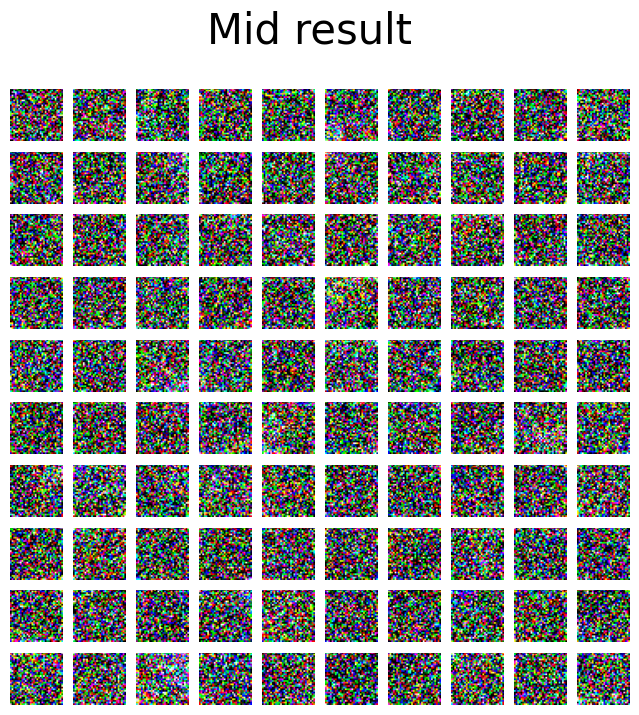

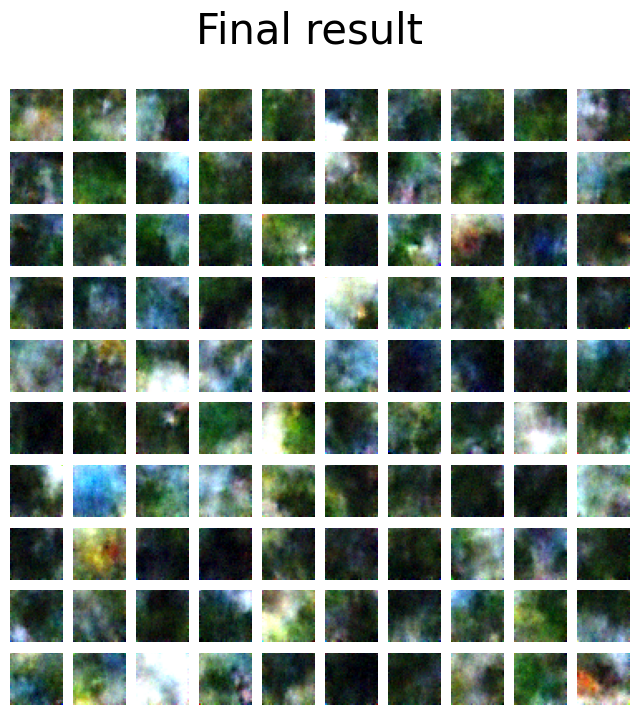

In [19]:
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")